In [1]:
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from collections import deque
from keras import Sequential, models
from keras import losses
from keras.layers import Dense
from keras.optimizers import adam
import warnings

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

Using TensorFlow backend.


(-0.07, 0.07)

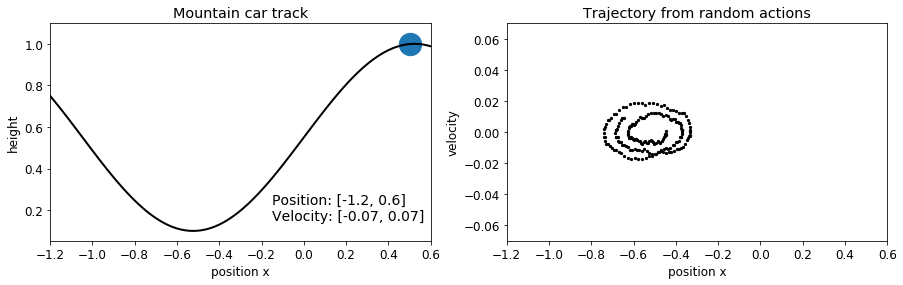

In [2]:
"""
Exploratory analysis
"""

fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize = (15, 4))

# Figure 1 - the environment of the moutaincar
x = np.linspace(-1.2, 0.6, 100)
ax0.plot(x, np.sin(3 * x) * 0.45 + 0.55, 'k-', lw = 2) # Curve of the track
ax0.scatter(0.5, 1, s = 500)
ax0.set_title('Mountain car track')
ax0.set_xlabel('position x')
ax0.set_ylabel('height')
ax0.set_xlim(-1.2, 0.6)

# Insert text
env = gym.make('MountainCar-v0')
space_low = env.observation_space.low
space_high = env.observation_space.high
pos = [space_low[0], space_high[0]]
vel = [space_low[1], space_high[1]]
ax0.text(-0.15, 0.15, 'Position: %s \nVelocity: %s' % (pos, vel), fontsize = 14)

# Figure 2 -  trajectory from a series of random actions
def random_actions(): # Get data from a series random actions
    env.reset()
    pos, vel = [], []
    while True:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        pos.append(observation[0])
        vel.append(observation[1])
        if done:
            break
    env.close()
    return pos, vel

pos, vel = random_actions()
ax1.scatter(pos, vel, color = 'k', s = 5)
ax1.set_title('Trajectory from random actions')
ax1.set_xlabel('position x')
ax1.set_ylabel('velocity')
ax1.set_xlim(-1.2, 0.6)
ax1.set_ylim(-0.07, 0.07)

In [0]:
class DQN():

    """ Implementation of deep q learning algorithm"""

    def __init__(self, action_space, state_space, epsilon, epsilon_min, epsilon_decay, discount_factor, learning_rate, batch_size, memory_size):

        """
        Initalize hyperparameters
        """

        self.action_space = action_space
        self.state_space = state_space 
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.model = self.build_model()

    def build_model(self):

        """
        The model is based on a simple neural network. The model is trying to predict 
        the return of reward by taking an action given the state of the current environment.
        """

        model = Sequential()
        model.add(Dense(24, input_shape = (self.state_space,), activation = 'relu'))
        model.add(Dense(24, activation = 'relu'))
        model.add(Dense(self.action_space, activation = 'linear'))
        model.compile(loss = 'mse', optimizer = adam(lr = 0.001))
        return model

    def save_model(self, filename = None):

        self.model.save(filename)

    def act(self, state):

        """
        To balance between exploration and exploitation, a epsilon-greedy policy is 
        introduced. It is a decaying probability, which the learning algorithm
        uses to choose between picking random action (exploration) or greedy action 
        based on existing knowledge (exploitation).
        """
        
        if random.uniform(0, 1) <= self.epsilon: # exploration
            return env.action_space.sample()
        else:
            act_values = self.model.predict(state) # exploitation
            return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):

        """
        Memroy collection. Save the memory that the agent observes and we will 
        use this data later
        """ 

        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        
        """
        Agent experiences replay memory during training. Replay memory will be 
        selected randomly, so that a batch of tranining samples are decorrelted. 
        """
      
        # Wait until we have enough sample available in memeory
        if len(self.memory) < self.batch_size: 
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        # Q function is updated using SARSA 
        states, next_states = np.squeeze(states), np.squeeze(next_states)
        targets = rewards + self.discount_factor * (np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets_full[[ind], [actions]] * (1 - self.learning_rate) + targets * self.learning_rate

        self.model.fit(states, targets_full, epochs = 1, verbose = 0)

    def total_energy(self, state):

        """
        We will use total energy to guide the agent so that even small victories could 
        have effects on learning. Total energy is the sum of its motion (i.e. kinetic energy) 
        and stored energy of position (i.e. potential energy).
        """
        
        x = state[0, 0] # position in x direction
        v = state[0, 1] # velocity

        # The potential energy is the difference of height between x and the valley at -0.5
        valley = -0.5
        potential_energy = math.sin(3 * x) * 0.45 + 0.55 - (math.sin(3 * valley) * 0.45 + 0.55)
        kinetic_energy = 0.5 * (v ** 2)

        return potential_energy + kinetic_energy

    def optimal_reward(self, next_state, state):

        """
        The agent is given a reward based on how much energy it has gain afer an action. Since the
        final goal is to reach the top on the right, the reward is doubled when the car 
        is at the right side of the hill. The reward is scaled to a range around {-1, 1}.
        """

        energy_gain = 10 * (self.total_energy(next_state) -  self.total_energy(state))

        valley = -0.5
        if next_state[0, 0] >= valley: # Scale the reward when the car is on the right side of the hill
          energy_gain = energy_gain * 2

        return energy_gain

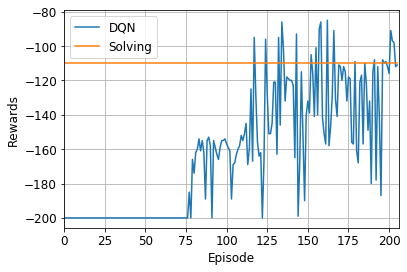

In [4]:
def train_dqn(episodes):

    """
    Train dqn model to interact with and learn from the environment
    """
    
    loss = []
    agent = DQN(
        action_space = env.action_space.n,
        state_space = env.observation_space.shape[0],
        epsilon = 1,
        epsilon_min = 0.001,
        epsilon_decay = 0.98,
        discount_factor = 0.98,
        learning_rate = 0.9,
        batch_size = 64,
        memory_size = 10000
    ) 
  
    for episode in range(episodes):
        env.seed(episode)
        state = env.reset()
        state = np.reshape(state, (1, 2))
        score = 0

        # Exploration is large in the beginning of training and then gradually reduced 
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay) 

        while True:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, (1, 2))
            score -= 1
            reward = agent.optimal_reward(next_state, state)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()

            # The episode is done when the agent reaches the goal or 200 steps
            if done: 
                break
        env.close()
        loss.append(score)

        # Early stop 
        if np.average(loss[-10:]) >= -110:
            break

    agent.save_model(filename = 'MountainCar-v0-dqn.h5')
    return loss

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    ep = 500
    loss = train_dqn(ep)

    ### Visualize the process of training dqn model
    plt.subplots(figsize= (6, 4))
    plt.plot(list(range(len(loss))), loss, label = 'DQN')
    plt.plot(list(range(len(loss))), np.ones((len(loss), 1))* -110, label = 'Solving')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.legend(loc = 'upper left')
    plt.xlim(0, len(loss))
    plt.grid(True)
    plt.show()

In [5]:
def test_dqn(episode):

    """
    Valid dqn model with 100 trials. MountainCarContinuous-v0 defines "solving" 
    as getting average reward of 90.0 over 100 consecutive trials.
    """
  
    episodes = episode
    scores = []
    states = []

    for e in range(episodes):
        state = env.reset()
        score = 0
        while True:
            action = np.argmax(model.predict(np.array([state])))
            state, reward, done, _ = env.step(action)
            states.append(state)
            score += reward
            if done:
                scores.append(score)
                break
        env.close()
    return np.average(scores), states

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    model = models.load_model('MountainCar-v0-dqn.h5')
    ep = 100
    loss, states = test_dqn(ep)
    print('Average rewards in the last 100 episodes: {}'.format(loss))

Average rewards in the last 100 episodes: -108.13


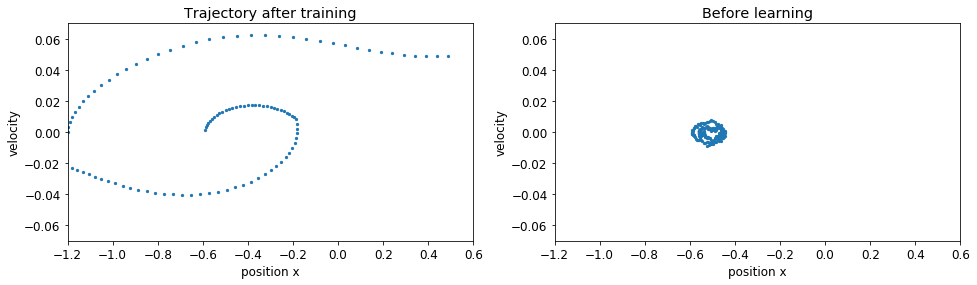

In [6]:
"""
Result analysis
"""

fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize = (16, 4))

# After training
pos = [s[0] for s in states]
vel = [s[1] for s in states]
first_time_reach_goal = [i for i, p in enumerate(pos) if p >= 0.5][0]
ax0.scatter(pos[:first_time_reach_goal], vel[:first_time_reach_goal], s = 5)
ax0.set_title('Trajectory after training')
ax0.set_xlabel('position x')
ax0.set_ylabel('velocity')
ax0.set_xlim(-1.2, 0.6)
ax0.set_ylim(-0.07, 0.07)
env.close()

# Before training
pos, vel = random_actions()
ax1.scatter(pos, vel, s = 5)
ax1.set_title('Before learning')
ax1.set_xlabel('position x')
ax1.set_ylabel('velocity')
ax1.set_xlim(-1.2, 0.6)
ax1.set_ylim(-0.07, 0.07)
env.close()

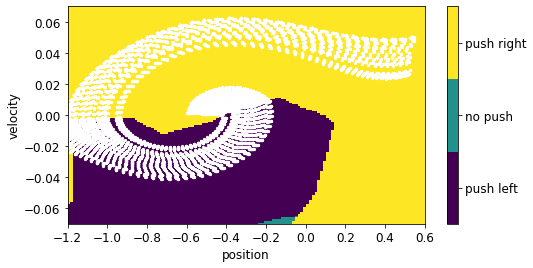

In [7]:
# Visualization of policy
fig, ax = plt.subplots(figsize = (8, 4))

poses = np.linspace(env.unwrapped.min_position, env.unwrapped.max_position, 128)
vels = np.linspace(-env.unwrapped.max_speed, env.unwrapped.max_speed, 128)
positions, velocities = np.meshgrid(poses, vels)

model = models.load_model('MountainCar-v0-dqn.h5')
@np.vectorize
def decide(position, velocity):
    return np.argmax(model.predict(np.array([[position, velocity]])))
action_values = decide(positions, velocities)
c = ax.pcolormesh(positions, velocities, action_values)


pos = [s[0] for s in states]
vel = [s[1] for s in states]
ax.scatter(pos, vel, s = 5, c = 'w')

ax.set_xlabel('position')
ax.set_ylabel('velocity')
ax.set_xlim(-1.2, 0.6)
cbar = fig.colorbar(c, ax = ax, boundaries = [-.5, .5, 1.5, 2.5], ticks = [0, 1, 2])
cbar.ax.set_yticklabels(['push left', 'no push', 'push right'])
fig.show()